# Assignment -2
## *__t-SNE visualization of Amazon reviews with polarity based color-coding__*

In [1]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import sqlite3
import nltk
from nltk.stem.porter import PorterStemmer
import re
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
con = sqlite3.connect('./database.sqlite')
df = pd.read_sql_query("""SELECT *
FROM Reviews
WHERE Score !=3
""",con)  

In [3]:
df = df.dropna()
# https://stackoverflow.com/questions/19913659/pandas-conditional-creation-of-a-series-dataframe-column
df['review'] = np.where(df['Score']>3, 'positive', 'negative')
# df.review.value_counts()

In [4]:
sorted_data=df.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
positive_reviews = df[df.review=='positive']
negative_reviews = df[df.review=='negative']
# https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.DataFrame.sample.html
negative_reviews = negative_reviews.sample(80000)
positive_reviews = positive_reviews.sample(80000)
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.concat.html
Amazon_80000 = pd.concat([positive_reviews, negative_reviews])


In [13]:
# final data set
DataPoints, Features = Amazon_80000.shape
l= Amazon_80000["review"].unique()
x,y= Amazon_80000["review"].value_counts()
print("Final Data \n")
# print(len(l))
print ("Total number of Datapoints -",DataPoints,'\n\n'
      'Total Number Features or Independent Variable -',Features-1,'\n')
print('The Positive review has label \"{}\" and \"{}\" datapoint \n'.format(l[0],x))
print('The Negatve review has class label \"{}\" and \"{}\" datapoints'.format(l[1],y))

Final Data 

Total number of Datapoints - 160000 

Total Number Features or Independent Variable - 10 

The Positive review has label "positive" and "80000" datapoint 

The Negatve review has class label "negative" and "80000" datapoints


## Text Preprocessing

In [14]:
import itertools

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext.lower()

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\';|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

# # cleaned Text
Amazon_80000['CleanedText']=list(map(cleanhtml,(map(cleanpunc,Amazon_80000['Text']))))

In [15]:
stop = set(stopwords.words('english')) #set of stopwords

sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
def list_of_words(sentence):
    word=[]
    for cleaned_words in sentence.split():
        if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):

            if(cleaned_words.lower() not in stop):
                s=(sno.stem(cleaned_words.lower()))#.encode('utf8')  #remoiving utf give 
                word.append(s) #list of all words used to describe positive reviews
            else:
                continue
        else:
            continue
    words=' '.join(str(e) for e in word)
    return words

Amazon_80000['WoutStopWords']=list(map(list_of_words,Amazon_80000['CleanedText']))


In [ ]:
X = Amazon_80000[['Time',"WoutStopWords",'review']]
X = X.sort_values(['Time'],ascending=True)
#using Pickle to save dataset genrated for future refrences
#https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_pickle.html
X.to_pickle("./Amazon_80000.pkl")

# Bag Of Words

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer() #in scikit-learn
final_count = count_vect.fit_transform(Amazon_5000['WoutStopWords'].values)
final_counts=final_count.toarray()

In [29]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(final_counts)

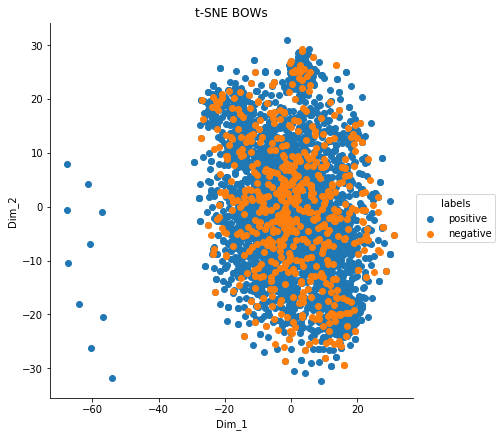

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
# saving results in csv in case of processing hung or to repeat data
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2"))
tsne_df["labels"]=Anazon_5000['review']

tsne_df.to_csv('Tsne_BoW.csv')

# # Ploting the result of tsne


sns.FacetGrid(tsne_df, hue="labels", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("t-SNE BOWs")
plt.show()

# TFID

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(Amazon_5000['WoutStopWords'].values)
final_tf_idf = final_tf_idf.toarray()

In [56]:
tsne_data_tfid = model.fit_transform(final_tf_idf)

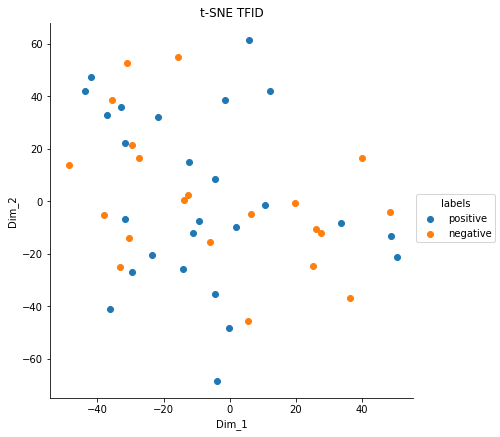

In [57]:
tsne_dfifd = pd.DataFrame(data=tsne_data_tfid, columns=("Dim_1", "Dim_2"))
tsne_dfifd["labels"]=Anazon_5000['review']

tsne_dfifd.to_csv('Tsne_TFID.csv')

# # Ploting the result of tsne

sns.FacetGrid(tsne_dfifd, hue="labels", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("t-SNE TFID")
plt.show()

# Avg W2V

In [13]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [15]:
def list_of_sent(df):
    i=0
    list_sent=[]
    for sent in df.values:
        filtered_sentence=[]
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if(cleaned_words.isalpha()):    
                    filtered_sentence.append(cleaned_words.lower())
                else:
                    continue 
        
        list_sent.append(filtered_sentence)
    
    return list_sent

In [18]:
list_all_words = list_of_sent(X['WoutStopWords'])

In [20]:
# w2v_model = Word2Vec(list_all_words,min_count=5,size=50, workers=4)
# words = list(w2v_model.wv.vocab)
print(len(words))

3338


In [21]:
Traing_vectors = []# the avg-w2v for each sentence/review is stored in this list
for sent in list_all_words: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    Traing_vectors.append(sent_vec)

In [26]:
W2V_array = np.asarray(Traing_vectors)

In [30]:
tsne_W2V = model.fit_transform(W2V_array)

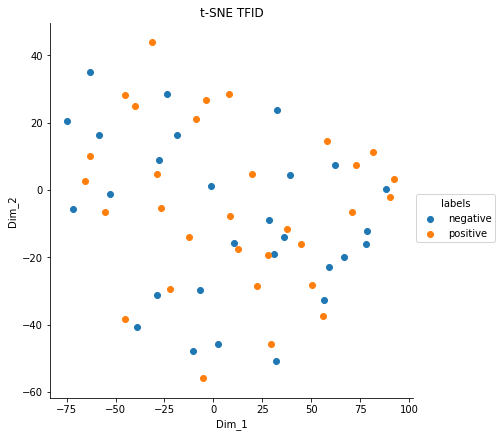

In [34]:
tsne_W2V = pd.DataFrame(data=tsne_W2V, columns=("Dim_1", "Dim_2"))
tsne_W2V["labels"]=Amazon_5000['review']

tsne_W2V.to_csv('Tsne_W2V.csv')

# # Ploting the result of tsne

sns.FacetGrid(tsne_W2V, hue="labels", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("t-SNE TFID")
plt.show()

# TFID Avg W2V

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer()
tf_idf = tf_idf_vect.fit_transform(X['WoutStopWords'].values)

In [78]:
tfidf_feat = tf_idf_vect.get_feature_names() 
# tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_train_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_all_words: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
           try:
            vec = w2v_model.wv[word]
#             print(vec)
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = tf_idf[row, tfidf_feat.index(word)]
#             print(tfidf)
            sent_vec += (vec * tfidf)
#             print(sent_vec)
        
            weight_sum += tfidf
#             print(weight_sum)
        except:
            pass
    sent_vec /= weight_sum
#     print(sent_vec)
    tfidf_train_vectors.append(sent_vec)
    row += 1

In [81]:
TFIDW2V_array = np.asarray(Traing_vectors)
tsne_TFIDW2V = model.fit_transform(TFIDW2V_array)

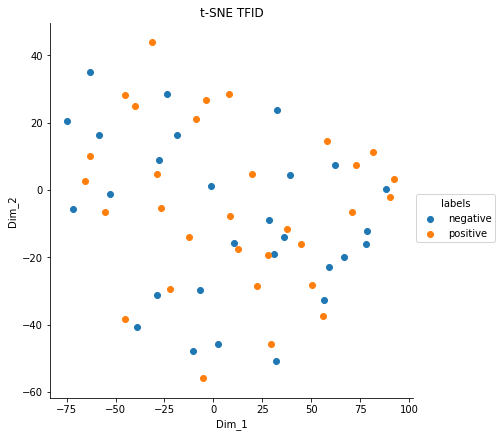

In [82]:
tsne_TFIDW2V = pd.DataFrame(data=tsne_TFIDW2V, columns=("Dim_1", "Dim_2"))
tsne_TFIDW2V["labels"]=Amazon_5000['review']

tsne_W2V.to_csv('Tsne_TFIDW2V.csv')

# # Ploting the result of tsne

sns.FacetGrid(tsne_TFIDW2V, hue="labels", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("t-SNE TFID")
plt.show()

In [9]:
negative_reviews.shape

(82037, 11)